<img src='images/pic1.jpg'/>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/My Drive/StackOverflow_Tag_Prediction

Mounted at /content/drive/
/content/drive/My Drive/StackOverflow_Tag_Prediction


In [ ]:
!pip3 install scikit-multilearn

     |████████████████████████████████| 92kB 2.4MB/s 


In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime
import zipfile

import pickle, os, gc

## Unzipping Test.zip and Train.zip- 

In [ ]:
with zipfile.ZipFile("./Train.zip","r") as trn, zipfile.ZipFile("./Test.zip","r") as tst:
    trn.extractall("./Train")
    tst.extractall("./Test")

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h2> 1.3 Real World / Business Objectives and Constraints </h2>

1. Predict as many tags as possible with high precision and recall.
2. Incorrect tags could impact customer experience on StackOverflow.
3. No strict latency constraints.

<h1>2. Machine Learning problem </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

Refer: https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data
<br>
All of the data is in 2 files: Train and Test.<br />
<pre>
<b>Train.csv</b> contains 4 columns: Id,Title,Body,Tags.<br />
<b>Test.csv</b> contains the same columns but without the Tags, which you are to predict.<br />
<b>Size of Train.csv</b> - 6.75GB<br />
<b>Size of Test.csv</b> - 2GB<br />
<b>Number of rows in Train.csv</b> = 6034195<br />
</pre>
The questions are randomized and contains a mix of verbose text sites as well as sites related to math and programming. The number of questions from each site may vary, and no filtering has been performed on the questions (such as closed questions).<br />
<br />


__Data Field Explaination__

Dataset contains 6,034,195 rows. The columns in the table are:<br />
<pre>
<b>Id</b> - Unique identifier for each question<br />
<b>Title</b> - The question's title<br />
<b>Body</b> - The body of the question<br />
<b>Tags</b> - The tags associated with the question in a space-seperated format (all lowercase, should not contain tabs '\t' or ampersands '&')<br />
</pre>

<br />

<h3>2.1.2 Example Data point </h3>

<pre>
<b>Title</b>:  Implementing Boundary Value Analysis of Software Testing in a C++ program?
<b>Body </b>: <pre><code>
        #include&lt;
        iostream&gt;\n
        #include&lt;
        stdlib.h&gt;\n\n
        using namespace std;\n\n
        int main()\n
        {\n
                 int n,a[n],x,c,u[n],m[n],e[n][4];\n         
                 cout&lt;&lt;"Enter the number of variables";\n         cin&gt;&gt;n;\n\n         
                 cout&lt;&lt;"Enter the Lower, and Upper Limits of the variables";\n         
                 for(int y=1; y&lt;n+1; y++)\n         
                 {\n                 
                    cin&gt;&gt;m[y];\n                 
                    cin&gt;&gt;u[y];\n         
                 }\n         
                 for(x=1; x&lt;n+1; x++)\n         
                 {\n                 
                    a[x] = (m[x] + u[x])/2;\n         
                 }\n         
                 c=(n*4)-4;\n         
                 for(int a1=1; a1&lt;n+1; a1++)\n         
                 {\n\n             
                    e[a1][0] = m[a1];\n             
                    e[a1][1] = m[a1]+1;\n             
                    e[a1][2] = u[a1]-1;\n             
                    e[a1][3] = u[a1];\n         
                 }\n         
                 for(int i=1; i&lt;n+1; i++)\n         
                 {\n            
                    for(int l=1; l&lt;=i; l++)\n            
                    {\n                 
                        if(l!=1)\n                 
                        {\n                    
                            cout&lt;&lt;a[l]&lt;&lt;"\\t";\n                 
                        }\n            
                    }\n            
                    for(int j=0; j&lt;4; j++)\n            
                    {\n                
                        cout&lt;&lt;e[i][j];\n                
                        for(int k=0; k&lt;n-(i+1); k++)\n                
                        {\n                    
                            cout&lt;&lt;a[k]&lt;&lt;"\\t";\n               
                        }\n                
                        cout&lt;&lt;"\\n";\n            
                    }\n        
                 }    \n\n        
                 system("PAUSE");\n        
                 return 0;    \n
        }\n
        </code></pre>\n\n
        <p>The answer should come in the form of a table like</p>\n\n
        <pre><code>       
        1            50              50\n       
        2            50              50\n       
        99           50              50\n       
        100          50              50\n       
        50           1               50\n       
        50           2               50\n       
        50           99              50\n       
        50           100             50\n       
        50           50              1\n       
        50           50              2\n       
        50           50              99\n       
        50           50              100\n
        </code></pre>\n\n
        <p>if the no of inputs is 3 and their ranges are\n
        1,100\n
        1,100\n
        1,100\n
        (could be varied too)</p>\n\n
        <p>The output is not coming,can anyone correct the code or tell me what\'s wrong?</p>\n'
<b>Tags </b>: 'c++ c'
</pre>

<h2>2.2 Mapping the real-world problem to a Machine Learning Problem </h2>

<h3> 2.2.1 Type of Machine Learning Problem </h3>

<p> It is a multi-label classification problem  <br>
<b>Multi-label Classification</b>: Multilabel classification assigns to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A question on Stackoverflow might be about any of C, Pointers, FileIO and/or memory-management at the same time or none of these. <br>
__Credit__: http://scikit-learn.org/stable/modules/multiclass.html
</p>

<h3>2.2.2 Performance metric </h3>

<b>Micro-Averaged F1-Score (Mean F Score) </b>: 
The F1 score can be interpreted as a weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

<i>F1 = 2 * (precision * recall) / (precision + recall)</i><br>

In the multi-class and multi-label case, this is the weighted average of the F1 score of each class. <br>

<b>'Micro f1 score': </b><br>
Calculate metrics globally by counting the total true positives, false negatives and false positives. This is a better metric when we have class imbalance.
<br>

<b>'Macro f1 score': </b><br>
Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
<br>

https://www.kaggle.com/wiki/MeanFScore <br>
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html <br>
<br>
<b> Hamming loss </b>: The Hamming loss is the fraction of labels that are incorrectly predicted. <br>
https://www.kaggle.com/wiki/HammingLoss <br>

<h1> 3. Exploratory Data Analysis </h1>

<h2> 3.1 Data Loading and Cleaning </h2>

<h3>3.1.1 Using Pandas with SQLite to Load the data</h3>

In [ ]:
#Creating db file from csv
#Learn SQL: https://www.w3schools.com/sql/default.asp
if not os.path.isfile('train.db'):
    start = datetime.now()
    disk_engine = create_engine('sqlite:///train.db')
    start = dt.datetime.now()
    chunksize = 180000
    j = 0
    index_start = 1
    for df in pd.read_csv('./Train/Train.csv', names=['Id', 'Title', 'Body', 'Tags'], chunksize=chunksize, iterator=True, encoding='utf-8', ):
        df.index += index_start
        j+=1
        print('{} rows'.format(j*chunksize))
        df.to_sql('data', disk_engine, if_exists='append')
        index_start = df.index[-1] + 1
    print("Time taken to run this cell :", datetime.now() - start)

180000 rows
360000 rows
540000 rows
720000 rows
900000 rows
1080000 rows
1260000 rows
1440000 rows
1620000 rows
1800000 rows
1980000 rows
2160000 rows
2340000 rows
2520000 rows
2700000 rows
2880000 rows
3060000 rows
3240000 rows
3420000 rows
3600000 rows
3780000 rows
3960000 rows
4140000 rows
4320000 rows
4500000 rows
4680000 rows
4860000 rows
5040000 rows
5220000 rows
5400000 rows
5580000 rows
5760000 rows
5940000 rows
6120000 rows
Time taken to run this cell : 0:11:17.971391


<h3> 3.1.2 Counting the number of rows </h3>

In [ ]:
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    num_rows = pd.read_sql_query("""SELECT count(*) FROM data""", con)
    #Always remember to close the database
    print("Number of rows in the database :","\n",num_rows['count(*)'].values[0])
    con.close()
    print("Time taken to count the number of rows :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cell to genarate train.db file")

Number of rows in the database : 
 6034196
Time taken to count the number of rows : 0:00:16.270514


<h3>3.1.3 Checking for duplicates </h3>

In [ ]:
#Learn SQl: https://www.w3schools.com/sql/default.asp
if os.path.isfile('train.db'):
    start = datetime.now()
    con = sqlite3.connect('train.db')
    df_no_dup = pd.read_sql_query('SELECT Title, Body, Tags, COUNT(*) as cnt_dup FROM data GROUP BY Title, Body, Tags', con)
    con.close()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the first to genarate train.db file")

Time taken to run this cell : 0:06:39.858461


In [ ]:
df_no_dup.head()
# we can observe that there are duplicates

,Title,Body,Tags,cnt_dup
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2


In [ ]:
print("number of duplicate questions :", num_rows['count(*)'].values[0]- df_no_dup.shape[0], "(",(1-((df_no_dup.shape[0])/(num_rows['count(*)'].values[0])))*100,"% )")

number of duplicate questions : 1827881 ( 30.292038906260256 % )


In [ ]:
# number of times each question appeared in our database
df_no_dup.cnt_dup.value_counts()

1    2656284
2    1272336
3     277575
4         90
5         25
6          5
Name: cnt_dup, dtype: int64

In [ ]:
start = datetime.now()
df_no_dup.fillna(" ",inplace=True)
df_no_dup["tag_count"] = df_no_dup["Tags"].apply(lambda text: len(text.split(" ")))
# adding a new feature number of tags per question
print("Time taken to run this cell :", datetime.now() - start)
df_no_dup.head()

Time taken to run this cell : 0:00:04.921135


,Title,Body,Tags,cnt_dup,tag_count
0,Implementing Boundary Value Analysis of S...,<pre><code>#include&lt;iostream&gt;\n#include&...,c++ c,1,2
1,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding,1,3
2,Dynamic Datagrid Binding in Silverlight?,<p>I should do binding for datagrid dynamicall...,c# silverlight data-binding columns,1,4
3,java.lang.NoClassDefFoundError: javax/serv...,"<p>I followed the guide in <a href=""http://sta...",jsp jstl,1,2
4,java.sql.SQLException:[Microsoft][ODBC Dri...,<p>I use the following code</p>\n\n<pre><code>...,java jdbc,2,2


In [ ]:
# distribution of number of tags per question
df_no_dup.tag_count.value_counts()

3    1206157
2    1111713
4     814996
1     568291
5     505158
Name: tag_count, dtype: int64

In [ ]:
#Creating a new database with no duplicates
if not os.path.isfile('train_no_dup.db'):
    disk_dup = create_engine("sqlite:///train_no_dup.db")
    no_dup = pd.DataFrame(df_no_dup, columns=['Title', 'Body', 'Tags'])
    no_dup.to_sql('no_dup_train',disk_dup)

In [ ]:
#This method seems more appropriate to work with this much data.
#creating the connection with database file.
if os.path.isfile('train_no_dup.db'):
    start = datetime.now()
    con = sqlite3.connect('train_no_dup.db')
    tag_data = pd.read_sql_query("""SELECT Tags FROM no_dup_train""", con)
    #Always remember to close the database
    con.close()

    # Let's now drop unwanted column.
    tag_data.drop(tag_data.index[0], inplace=True)
    #Printing first 5 columns from our data frame
    tag_data.head()
    print("Time taken to run this cell :", datetime.now() - start)
else:
    print("Please download the train.db file from drive or run the above cells to genarate train.db file")

Time taken to run this cell : 0:01:54.580718


<h2> 3.2 Analysis of Tags </h2>

<h3> 3.2.1 Total number of unique tags </h3>

In [ ]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(tag_data['Tags'])

In [ ]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 4206314
Number of unique tags : 42048


In [ ]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.asp.net-mvc', '.aspxauth', '.bash-profile', '.class-file', '.cs-file', '.doc', '.drv', '.ds-store']


<h3> 3.2.3 Number of times a tag appeared </h3>

In [ ]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [ ]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,18
1,.app,37
2,.asp.net-mvc,1
3,.aspxauth,21
4,.bash-profile,138


In [ ]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

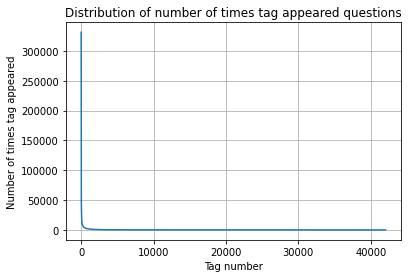

In [ ]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

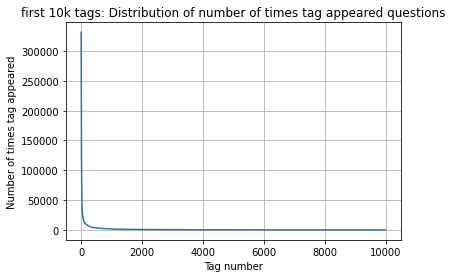

400 [331505  44829  22429  17728  13364  11162  10029   9148   8054   7151
   6466   5865   5370   4983   4526   4281   4144   3929   3750   3593
   3453   3299   3123   2989   2891   2738   2647   2527   2431   2331
   2259   2186   2097   2020   1959   1900   1828   1770   1723   1673
   1631   1574   1532   1479   1448   1406   1365   1328   1300   1266
   1245   1222   1197   1181   1158   1139   1121   1101   1076   1056
   1038   1023   1006    983    966    952    938    926    911    891
    882    869    856    841    830    816    804    789    779    770
    752    743    733    725    712    702    688    678    671    658
    650    643    634    627    616    607    598    589    583    577
    568    559    552    545    540    533    526    518    512    506
    500    495    490    485    480    477    469    465    457    450
    447    442    437    432    426    422    418    413    408    403
    398    393    388    385    381    378    374    370    367    365
  

In [ ]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

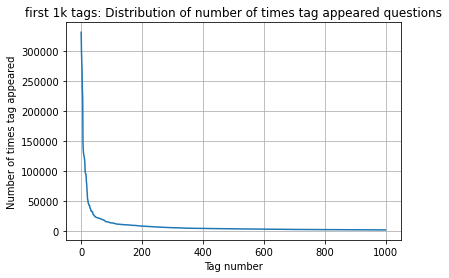

200 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483
   3453   3427   3396   3363   3326   3299   3272   3232   3196   3168
   3123   3094   3073   3050   3012   2989   2984   2953   2934   2903
   2891   2844   2819   2784   2754   2738   2726   2708   2681   2669
   2647   2621   2604   2594   2556   2527   2510   2482   2460   2444
  

In [ ]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

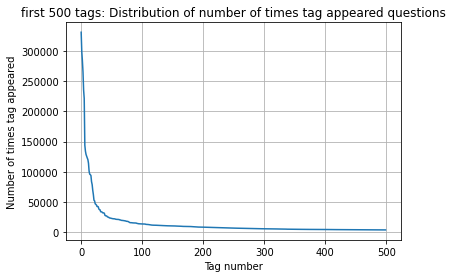

100 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703
  13364  13157  12407  11658  11228  11162  10863  10600  10350  10224
  10029   9884   9719   9411   9252   9148   9040   8617   8361   8163
   8054   7867   7702   7564   7274   7151   7052   6847   6656   6553
   6466   6291   6183   6093   5971   5865   5760   5577   5490   5411
   5370   5283   5207   5107   5066   4983   4891   4785   4658   4549
   4526   4487   4429   4335   4310   4281   4239   4228   4195   4159
   4144   4088   4050   4002   3957   3929   3874   3849   3818   3797
   3750   3703   3685   3658   3615   3593   3564   3521   3505   3483]


In [ ]:
plt.plot(tag_counts[0:500])
plt.title('first 500 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:500:5]), tag_counts[0:500:5])

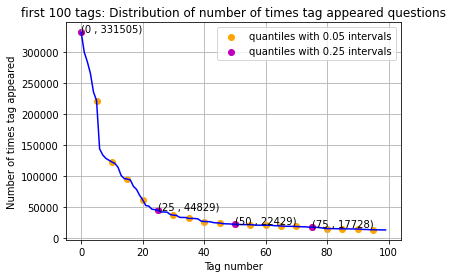

20 [331505 221533 122769  95160  62023  44829  37170  31897  26925  24537
  22429  21820  20957  19758  18905  17728  15533  15097  14884  13703]


In [ ]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [ ]:
# Store tags greater than 10K in one list
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
#Print the length of the list
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
# Store tags greater than 100K in one list
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
#Print the length of the list.
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

153 Tags are used more than 10000 times
14 Tags are used more than 100000 times


<b>Observations:</b><br />
1. There are total 153 tags which are used more than 10000 times.
2. 14 tags are used more than 100000 times.
3. Most frequent tag (i.e. c#) is used 331505 times.
4. Since some tags occur much more frequenctly than others, Micro-averaged F1-score is the appropriate metric for this probelm.

<h3> 3.2.4 Tags Per Question </h3>

In [ ]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 4206314 datapoints.
[3, 4, 2, 2, 3]


In [ ]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 0
Avg. number of tags per question: 2.899438


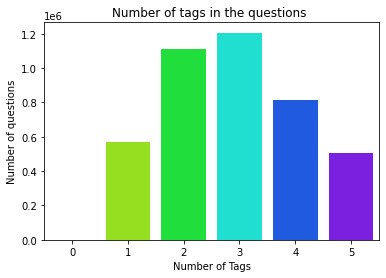

In [ ]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

<b>Observations:</b><br />
1. Maximum number of tags per question: 5
2. Minimum number of tags per question: 1
3. Avg. number of tags per question: 2.899
4. Most of the questions are having 2 or 3 tags

<h3>3.2.5 Most Frequent Tags </h3>

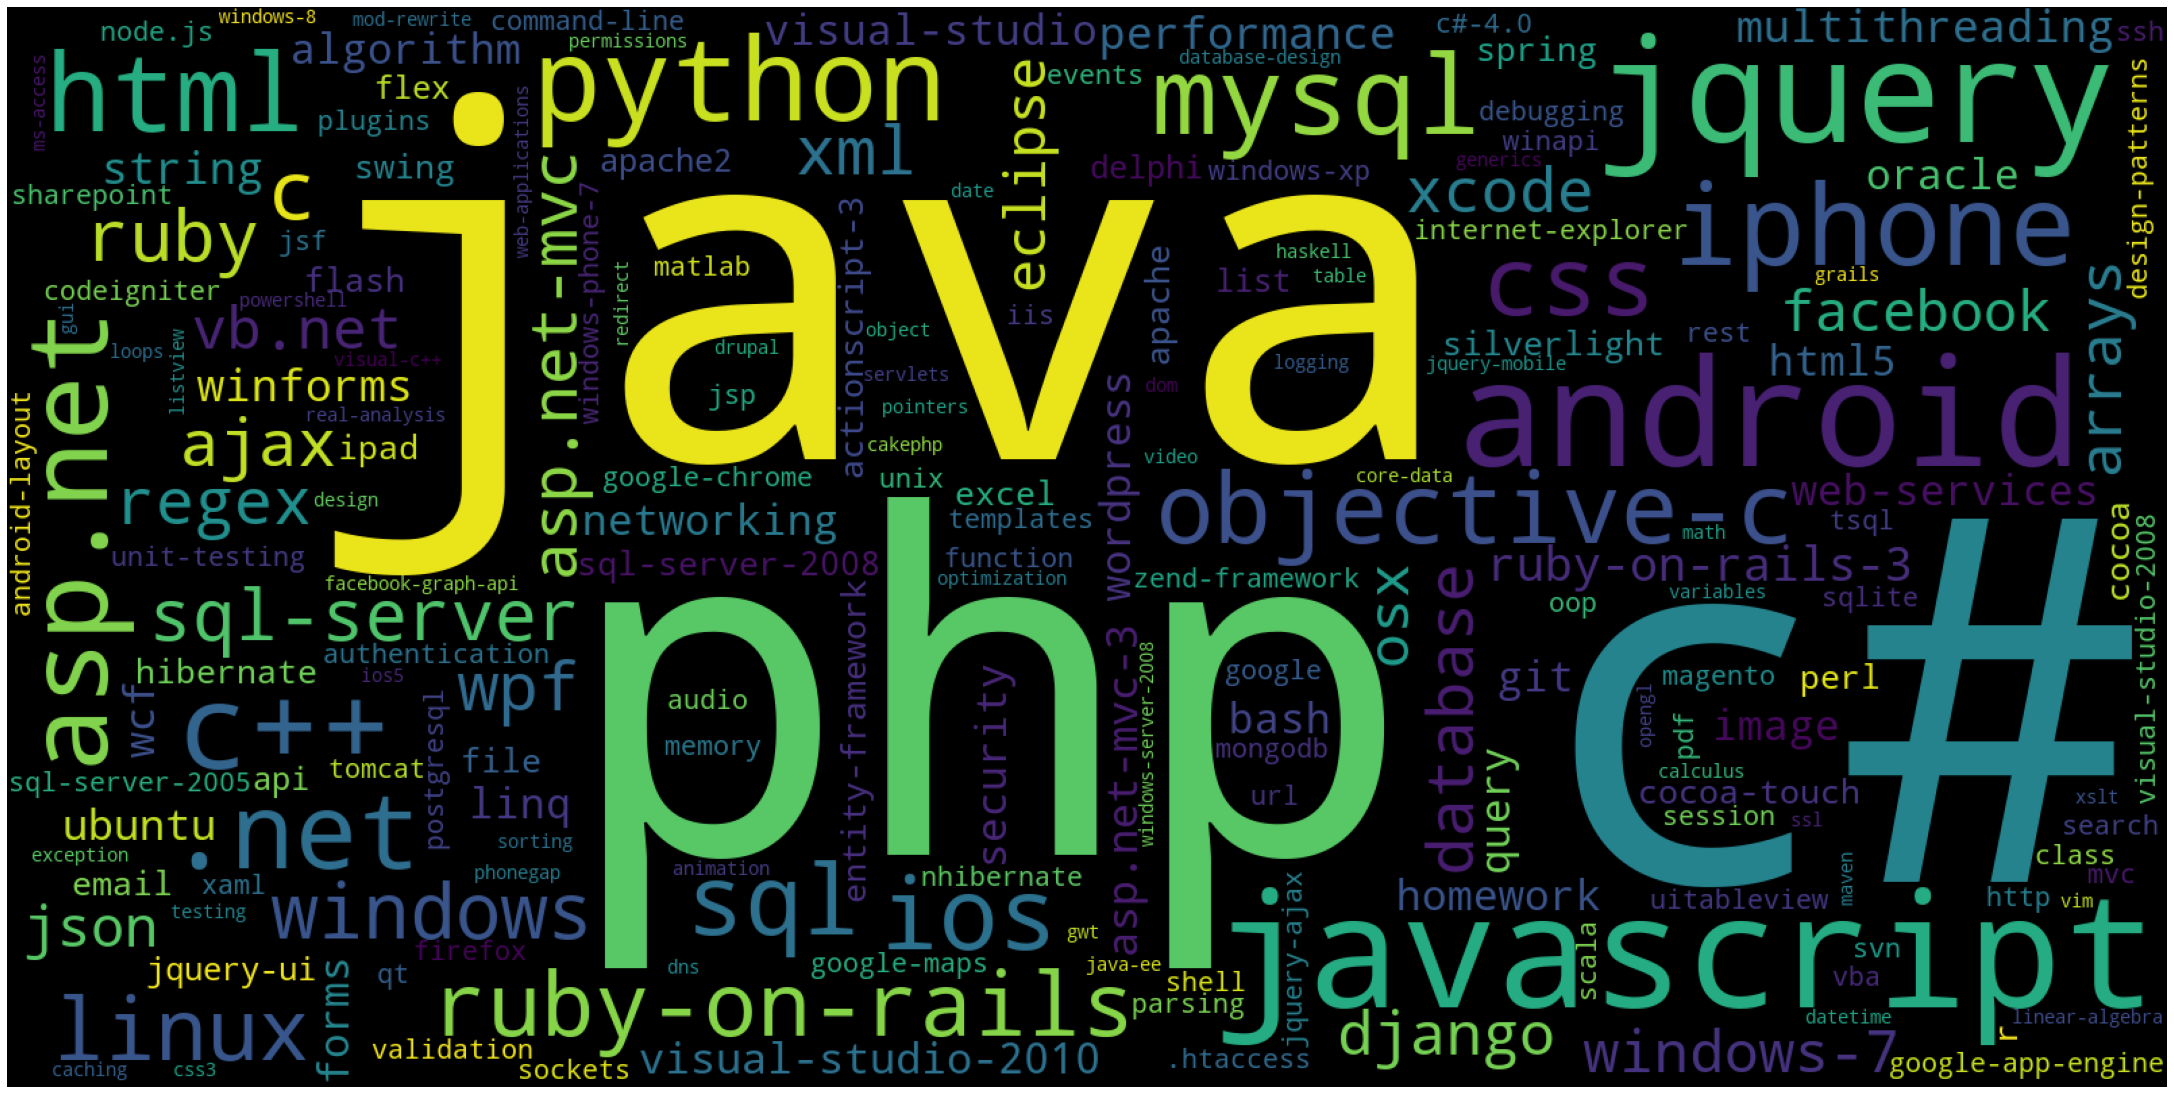

Time taken to run this cell : 0:00:07.351561


In [ ]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

<b>Observations:</b><br />
A look at the word cloud shows that "c#", "java", "php", "asp.net", "javascript", "c++" are some of the most frequent tags.

<h3> 3.2.6 The top 20 tags </h3>

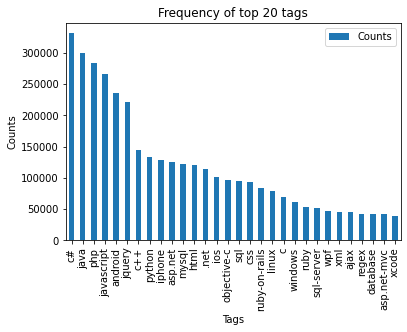

In [ ]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

<b>Observations:</b><br />
1. Majority of the most frequent tags are programming language.
2. C# is the top most frequent programming language.
3. Android, IOS, Linux and windows are among the top most frequent operating systems.

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [ ]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

#sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
#create_database_table("Processed.db", sql_create_table)

In [ ]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table
start = datetime.now()
read_db = 'train_no_dup.db'
write_db = 'Processed.db'
if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 1000000;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer = conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")
print("Time taken to run this cell :", datetime.now() - start)

__ we create a new data base to store the sampled and preprocessed questions __

In [ ]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/

start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:

    is_code = 0
    title, question, tags = row[0], row[1], row[2]

    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x

    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))

    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))

    title=title.encode('utf-8')

    question=str(title)+" "+str(question)
    question=re.sub(r'[^A-Za-z]+',' ',question)
    words=word_tokenize(str(question.lower()))

    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))

    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
number of questions completed= 600000
number of questions completed= 700000
number of questions completed= 800000
number of questions completed= 900000
Avg. length of questions(Title+Body) before processing: 1169
Avg. length of questions(Title+Body) after processing: 327
Percent of questions containing code: 57
Time taken to run this cell : 0:47:05.946582


In [ ]:
# dont forget to close the connections, or else you will end up with locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('ef code first defin one mani relationship differ key troubl defin one zero mani relationship entiti ef object model look like use fluent api object composit pk defin batch id batch detail id use fluent api object composit pk defin batch detail id compani id map exist databas tpt basic idea submittedtransact zero mani submittedsplittransact associ navig realli need one way submittedtransact submittedsplittransact need dbcontext class onmodelcr overrid map class lazi load occur submittedtransact submittedsplittransact help would much appreci edit taken advic made follow chang dbcontext class ad follow onmodelcr overrid must miss someth get follow except thrown submittedtransact key batch id batch detail id zero one mani submittedsplittransact key batch detail id compani id rather assum convent creat relationship two object configur requir sinc obvious wrong',)
--------------------------------------------------------------------------------------------------

In [ ]:
#Taking 1 Million entries to a dataframe.
write_db = 'Processed.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

,question,tags
0,chang cpu soni vaio pcg grx tri everywher find...,cpu motherboard sony-vaio replacement disassembly
1,display size grayscal qimag qt abl display ima...,c++ qt qt4
2,datagrid selecteditem set back null eventtocom...,mvvm silverlight-4.0
3,filter string collect base listview item resol...,c# winforms string listview collections
4,disabl home button without use type keyguard c...,android android-layout android-manifest androi...


In [ ]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 999999
number of dimensions : 2


<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

In [ ]:
# binary='true' will give a binary vectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [ ]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

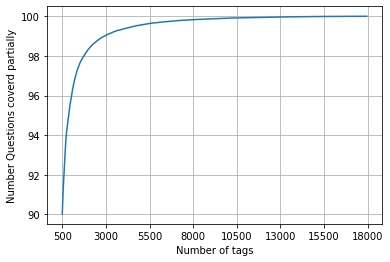

with  5500 tags we are covering  99.035 % of questions


In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 50(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")

In [ ]:
multilabel_yx = tags_to_choose(5500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 9645 out of  999999


In [ ]:
print("Number of tags in sample :", multilabel_y.shape[1])
print("number of tags taken :", multilabel_yx.shape[1],"(",(multilabel_yx.shape[1]/multilabel_y.shape[1])*100,"%)")

Number of tags in sample : 35422
number of tags taken : 5500 ( 15.527073570097679 %)


__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [ ]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)

y_train = multilabel_yx[0:train_size,:]
y_test = multilabel_yx[train_size:total_size,:]

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (799999, 5500)
Number of data points in test data : (200000, 5500)


<h2>4.3 Featurizing data </h2>

In [ ]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:09:50.460431


In [ ]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Diamensions of train data X: (799999, 88244) Y : (799999, 5500)
Diamensions of test data X: (200000, 88244) Y: (200000, 5500)


In [ ]:
# https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/
#https://stats.stackexchange.com/questions/117796/scikit-multi-label-classification
# classifier = LabelPowerset(GaussianNB())
"""
from skmultilearn.adapt import MLkNN
classifier = MLkNN(k=21)

# train
classifier.fit(x_train_multilabel, y_train)

# predict
predictions = classifier.predict(x_test_multilabel)
print(accuracy_score(y_test,predictions))
print(metrics.f1_score(y_test, predictions, average = 'macro'))
print(metrics.f1_score(y_test, predictions, average = 'micro'))
print(metrics.hamming_loss(y_test,predictions))

"""
# we are getting memory error because the multilearn package 
# is trying to convert the data into dense matrix
# ---------------------------------------------------------------------------
#MemoryError                               Traceback (most recent call last)
#<ipython-input-170-f0e7c7f3e0be> in <module>()
#----> classifier.fit(x_train_multilabel, y_train)

"\nfrom skmultilearn.adapt import MLkNN\nclassifier = MLkNN(k=21)\n\n# train\nclassifier.fit(x_train_multilabel, y_train)\n\n# predict\npredictions = classifier.predict(x_test_multilabel)\nprint(accuracy_score(y_test,predictions))\nprint(metrics.f1_score(y_test, predictions, average = 'macro'))\nprint(metrics.f1_score(y_test, predictions, average = 'micro'))\nprint(metrics.hamming_loss(y_test,predictions))\n\n"

<h2> 4.4 Applying Logistic Regression with OneVsRest Classifier </h2>

In [ ]:
# this will be taking so much time try not to run it, download the lr_with_equal_weight.pkl file and use to predict
# This takes about 6-7 hours to run.
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict(x_test_multilabel)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))


accuracy : 0.081965
macro f1 score : 0.0963020140154
micro f1 scoore : 0.374270748817
hamming loss : 0.00041225090909090907
Precision recall report :
              precision    recall  f1-score   support

          0       0.62      0.23      0.33     15760
          1       0.79      0.43      0.56     14039
          2       0.82      0.55      0.66     13446
          3       0.76      0.42      0.54     12730
          4       0.94      0.76      0.84     11229
          5       0.85      0.64      0.73     10561
          6       0.70      0.30      0.42      6958
          7       0.87      0.61      0.72      6309
          8       0.70      0.40      0.50      6032
          9       0.78      0.43      0.55      6020
         10       0.86      0.62      0.72      5707
         11       0.52      0.17      0.25      5723
         12       0.55      0.10      0.16      5521
         13       0.59      0.25      0.35      4722
         14       0.61      0.22      0.32      4468


In [ ]:
from sklearn.externals import joblib
joblib.dump(classifier, 'lr_with_equal_weight.pkl') 

<h2> 4.5 Modeling with less data points (0.5M data points) and more weight to title and 500 tags only. </h2>

In [ ]:
sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Titlemoreweight.db", sql_create_table)

In [ ]:
# http://www.sqlitetutorial.net/sqlite-delete/
# https://stackoverflow.com/questions/2279706/select-random-row-from-a-sqlite-table

read_db = 'train_no_dup.db'
write_db = 'Titlemoreweight.db'
train_datasize = 150000

if os.path.isfile(read_db):
    conn_r = create_connection(read_db)
    if conn_r is not None:
        reader = conn_r.cursor()
        # for selecting first 0.15M rows
        reader.execute("SELECT Title, Body, Tags From no_dup_train LIMIT 150001;")
        # for selecting random points
        #reader.execute("SELECT Title, Body, Tags From no_dup_train ORDER BY RANDOM() LIMIT 200001;")

if os.path.isfile(write_db):
    conn_w = create_connection(write_db)
    if conn_w is not None:
        tables = checkTableExists(conn_w)
        writer =conn_w.cursor()
        if tables != 0:
            writer.execute("DELETE FROM QuestionsProcessed WHERE 1")
            print("Cleared All the rows")


Tables in the databse:
QuestionsProcessed
Cleared All the rows


<h3> 4.5.1 Preprocessing of questions </h3>

<ol> 
    <li> Separate Code from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> <b> Give more weightage to title : Add title three times to the question </b> </li>
   
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#http://www.bernzilla.com/2008/05/13/selecting-a-random-row-from-an-sqlite-table/
start = datetime.now()
preprocessed_data_list=[]
reader.fetchone()
questions_with_code=0
len_pre=0
len_post=0
questions_proccesed = 0

for row in reader:
    
    is_code = 0
    
    title, question, tags = row[0], row[1], str(row[2])
    
    if '<code>' in question:
        questions_with_code+=1
        is_code = 1
    x = len(question)+len(title)
    len_pre+=x
    
    code = str(re.findall(r'<code>(.*?)</code>', question, flags=re.DOTALL))
    
    question=re.sub('<code>(.*?)</code>', '', question, flags=re.MULTILINE|re.DOTALL)
    question=striphtml(question.encode('utf-8'))
    
    title=title.encode('utf-8')
    
    # adding title three time to the data to increase its weight
    # add tags string to the training data
    
    question=str(title)+" "+str(title)+" "+str(title)+" "+question
    
#     if questions_proccesed<=train_datasize:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question+" "+str(tags)
#     else:
#         question=str(title)+" "+str(title)+" "+str(title)+" "+question

    question=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question)
    words=word_tokenize(str(question.lower()))
    
    #Removing all single letter and and stopwords from question exceptt for the letter 'c'
    question=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    
    len_post+=len(question)
    tup = (question,code,tags,x,len(question),is_code)
    questions_proccesed += 1
    writer.execute("insert into QuestionsProcessed(question,code,tags,words_pre,words_post,is_code) values (?,?,?,?,?,?)",tup)
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

print("Time taken to run this cell :", datetime.now() - start)

number of questions completed= 100000
Avg. length of questions(Title+Body) before processing: 1222
Avg. length of questions(Title+Body) after processing: 430
Percent of questions containing code: 57
Time taken to run this cell : 0:05:28.746260


In [ ]:
# never forget to close the conections or else we will end up with database locks
conn_r.commit()
conn_w.commit()
conn_r.close()
conn_w.close()

__ Sample quesitons after preprocessing of data __

In [ ]:
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        reader =conn_r.cursor()
        reader.execute("SELECT question From QuestionsProcessed LIMIT 10")
        print("Questions after preprocessed")
        print('='*100)
        reader.fetchone()
        for row in reader:
            print(row)
            print('-'*100)
conn_r.commit()
conn_r.close()

Questions after preprocessed
('java.sql.sqlexcept microsoft odbc driver manag invalid descriptor index java.sql.sqlexcept microsoft odbc driver manag invalid descriptor index java.sql.sqlexcept microsoft odbc driver manag invalid descriptor index use follow code display caus solv',)
----------------------------------------------------------------------------------------------------
('better way updat feed fb php sdk better way updat feed fb php sdk better way updat feed fb php sdk novic facebook api read mani tutori still confused.i find post feed api method like correct second way use curl someth like way better',)
----------------------------------------------------------------------------------------------------
('btnadd click event open two window record ad btnadd click event open two window record ad btnadd click event open two window record ad open window search.aspx use code hav add button search.aspx nwhen insert record btnadd click event open anoth window nafter insert record 

__ Saving Preprocessed data to a Database __

In [ ]:
#Taking 0.15 Million entries to a dataframe.
write_db = 'Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
conn_r.commit()
conn_r.close()

In [ ]:
preprocessed_data.head()

,question,tags
0,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
1,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
2,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk
3,btnadd click event open two window record ad b...,javascript asp.net web
4,sql inject issu prevent correct form submiss p...,php forms


In [ ]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 149998
number of dimensions : 2


__ Converting string Tags to multilable output variables __ 

In [ ]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

__ Selecting 500 Tags __

In [ ]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

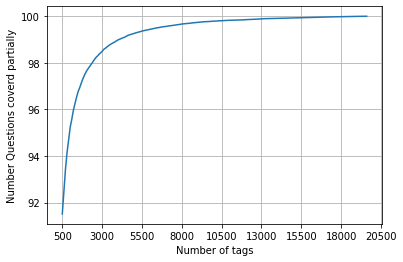

with  5500 tags we are covering  99.363 % of questions
with  500 tags we are covering  91.515 % of questions


In [ ]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [ ]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 12728 out of  149998


In [ ]:
x_train=preprocessed_data.head(120000)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 120000)

y_train = multilabel_yx[0:120000,:]
y_test = multilabel_yx[120000:preprocessed_data.shape[0],:]

In [ ]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (120000, 500)
Number of data points in test data : (29998, 500)


In [ ]:
with open("y_train.pkl", 'wb') as train : 
    pickle.dump(y_train, train)

with open("y_test.pkl", 'wb') as test : 
    pickle.dump(y_test, test)

with open("x_train_org.pkl", 'wb') as xtrain : 
    pickle.dump(x_train, xtrain)

with open("x_test_org.pkl", 'wb') as xtest : 
    pickle.dump(x_test, xtest)

del x_test, x_train, preprocessed_data, xtest, xtrain
gc.collect()

10266

<h3> 4.5.2 Featurizing data with TfIdf vectorizer </h3>

In [ ]:
start = datetime.now()

x_train = pickle.load(open("x_train_org.pkl",'rb'))
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=75000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,4))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])


with open("x_train.pkl", 'wb') as train : 
    pickle.dump(x_train_multilabel, train)

del x_train_multilabel, x_train
gc.collect()

x_test = pickle.load(open("x_test_org.pkl",'rb'))
x_test_multilabel = vectorizer.transform(x_test['question'])

with open("x_test.pkl", 'wb') as test : 
    pickle.dump(x_test_multilabel, test)

del x_test_multilabel, x_test
gc.collect()

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:06:32.339510


In [ ]:
x_train_multilabel = pickle.load(open("x_train.pkl",'rb'))
x_test_multilabel = pickle.load(open("x_test.pkl",'rb'))
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :", y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:", y_test.shape)

Dimensions of train data X: (120000, 75000) Y : (120000, 500)
Dimensions of test data X: (29998, 75000) Y: (29998, 500)


In [ ]:
del x_train_multilabel, x_test_multilabel
gc.collect()

842

<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import joblib

In [ ]:
#@title
def tradeoff_plot1D(params, TestScore, TrainScore, ax = None, xlabel = "Parameter", ylabel = "Score", plt_test = {}, plt_train = {}) :

  
    """

    params : Parameters of GridSearchCV or RandomSearchCV, can be obtained from .cv_results_['name of parameter'] attribute
  
    TestScore : "y" values for test plot, obtain using .cv_results_['mean_test_score'] 
              attribute of GrdiSearchCV or RandomSearchCV object 
  
    TrainScore : "y" values for train plot, obtain using cv_results_['mean_train_score'] 
              attribute of GrdiSearchCV or RandomSearchCV object 
  
    **plt_test : create a dictionary with keys as argument names and their respective values as items for train plot
  
    **plt_train : create a dictionary with keys as argument names and their respective values as items for train plot

    ax : can assign axes if None then automatically takes current axes
    
    """

    if "color" not in plt_train.keys():
      plt_train['color'] = "green"

    if "marker" not in plt_train.keys():
        plt_train['marker'] = "o"

    if "color" not in plt_test.keys():
      plt_test['color'] = "red"

    if "marker" not in plt_test.keys():
        plt_test['marker'] = "o"


    plt.plot(params, TestScore, label = "Performance on Validation Data", **plt_test)
    plt.plot(params, TrainScore, label = "Performance on Training Data", **plt_train)
    
    xs = np.concatenate((params,params), axis = 0)
    ys = np.concatenate((TestScore,TrainScore), axis = 0)

    for x,y in zip(xs,ys):

      label = f"({x:.2E},{y:.2})"

      plt.annotate(label, # this is the text
                   (x,y), # this is the point to label
                   textcoords="offset points", # how to position the text
                   xytext=(0,10), # distance from text to points (x,y)
                   ha='center') # horizontal alignment can be left, right or center

    plt.legend()
    plt.xticks(params, rotation = -45)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title("Train vs Val. Performance")

    if ax == None : 
        ax = plt.gca()
        ax.set_xscale('log')
        fig = plt.gcf()
        fig.set_size_inches(11,8)


### Hyperparamter tuning SGDClassifier using pipelines to prevent data leakage: 

In [ ]:
with open("x_test_org.pkl", 'rb') as test, open("x_train_org.pkl", 'rb') as train, open("y_test.pkl", 'rb') as ytest, open("y_train.pkl","rb") as ytrain: 
    x_test = pickle.load(test)
    x_train = pickle.load(train)
    y_test = pickle.load(ytest)
    y_train = pickle.load(ytrain)

In [ ]:
start = datetime.now()

steps_ovr_logreg = Pipeline([
                             ("Vectorizer", TfidfVectorizer(min_df=0.00009, max_features=75000, smooth_idf=True, norm="l2",\
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))),
                             ("OVRlogreg", OneVsRestClassifier(estimator = SGDClassifier(loss='log', penalty='l1')))
                            ])

steps_space =  {'OVRlogreg__estimator__alpha' : np.logspace(-9, 0, num = 6)}

OptLogReg = GridSearchCV(steps_ovr_logreg, steps_space, scoring = 'f1_micro', 
                         cv = 3, 
                         return_train_score=True, 
                         n_jobs=-1,
                         refit = True
                        )

OptLogReg.fit(x_train['question'], y_train)

del x_train, x_test
gc.collect()

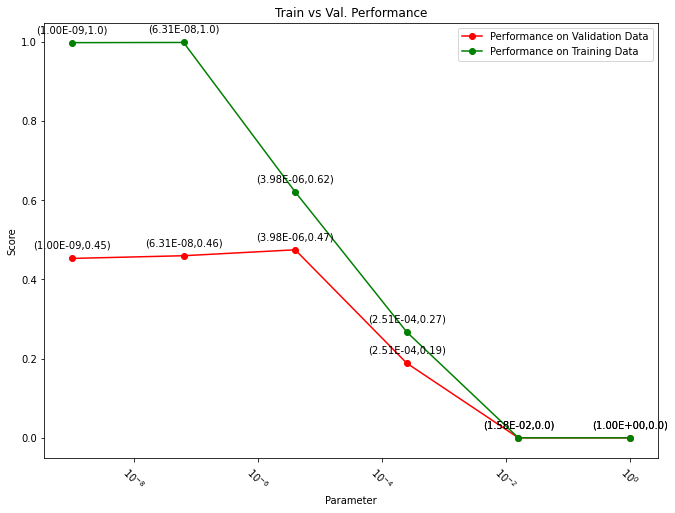

In [ ]:
%matplotlib inline

tradeoff_plot1D(params = OptLogReg.cv_results_['param_OVRlogreg__estimator__alpha'].compressed(), 
                TestScore = OptLogReg.cv_results_['mean_test_score'], 
                TrainScore = OptLogReg.cv_results_['mean_train_score'])

In [ ]:
with open("x_test.pkl", 'rb') as test, open("x_train.pkl", 'rb') as train: 
    x_test_multilabel = pickle.load(test)
    x_train_multilabel = pickle.load(train)

In [ ]:
OptClassifier = OneVsRestClassifier(estimator = SGDClassifier(loss='log', penalty='l1', alpha = 4e-06))
OptClassifier.fit(x_train_multilabel, y_train)

predictions = OptClassifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21343333333333334
Hamming loss  0.0029899333333333333
Micro-average quality numbers
Precision: 0.7000, Recall: 0.3473, F1-measure: 0.4643
Macro-average quality numbers
Precision: 0.5551, Recall: 0.2695, F1-measure: 0.3431
              precision    recall  f1-score   support

           0       0.77      0.38      0.51      1111
           1       0.67      0.23      0.34      2052
           2       0.64      0.39      0.49      2388
           3       0.73      0.53      0.62      2226
           4       0.79      0.45      0.58      2014
           5       0.55      0.11      0.19       642
           6       0.81      0.38      0.52      1756
           7       0.93      0.68      0.79      1690
           8       0.69      0.22      0.33       341
           9       0.78      0.77      0.78      2344
          10       0.65      0.38      0.48       821
          11       0.57      0.22      0.32      1143
          12       0.84      0.35      0.49       768
        

In [ ]:
joblib.dump(OptClassifier, "Optimal_OVRSGD_triple_title_wgt.pkl")

del OptLogReg, predictions, x_train_multilabel, x_test_multilabel
gc.collect()

### Hyperparamter tuning Logistic Regression using pipelines to prevent data leakage: 

In [ ]:
with open("x_test_org.pkl", 'rb') as test, open("x_train_org.pkl", 'rb') as train, open("y_test.pkl", 'rb') as ytest, open("y_train.pkl","rb") as ytrain: 
    x_test = pickle.load(test)
    x_train = pickle.load(train)
    y_test = pickle.load(ytest)
    y_train = pickle.load(ytrain)

In [ ]:
start = datetime.now()

steps_ovr_logreg2 = Pipeline([
                             ("Vectorizer", TfidfVectorizer(min_df=0.00009, max_features=75000, smooth_idf=True, norm="l2",\
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))),
                             ("OVRlogreg2", OneVsRestClassifier(estimator = LogisticRegression(penalty='l1', solver='liblinear')))
                            ])

steps_space =  {'OVRlogreg2__estimator__C' : np.logspace(-8, 8, num = 6)}

OptLogReg2 = GridSearchCV(steps_ovr_logreg2, steps_space, scoring = 'f1_micro', 
                         cv = 2, 
                         return_train_score=True, 
                         n_jobs=-1,
                         refit = True
                        )

OptLogReg2.fit(x_train['question'], y_train)

print("Time taken to run this cell :", datetime.now() - start)

del x_train, x_test
gc.collect()

Time taken to run this cell : 2:58:45.999939


980

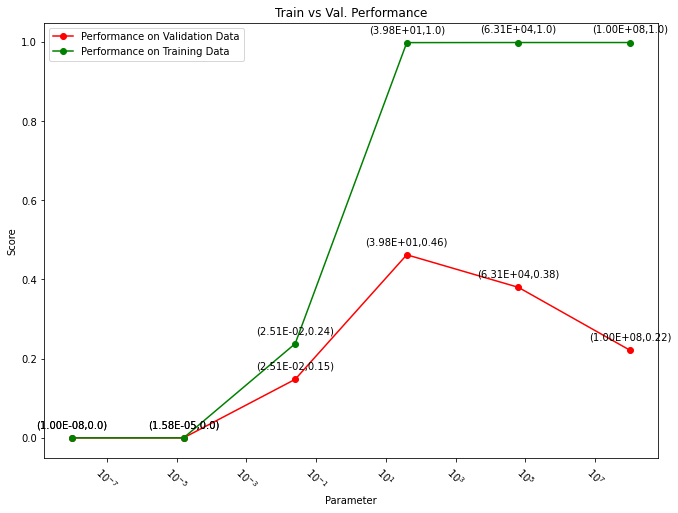

In [ ]:
%matplotlib inline

tradeoff_plot1D(params = OptLogReg2.cv_results_['param_OVRlogreg2__estimator__C'].compressed(), 
                TestScore = OptLogReg2.cv_results_['mean_test_score'], 
                TrainScore = OptLogReg2.cv_results_['mean_train_score'])

In [ ]:
with open("x_test.pkl", 'rb') as test, open("x_train.pkl", 'rb') as train: 
    x_test_multilabel = pickle.load(test)
    x_train_multilabel = pickle.load(train)

In [ ]:
OptClassifier = OneVsRestClassifier(estimator = LogisticRegression(penalty='l1', C = 4, solver='liblinear'))
OptClassifier.fit(x_train_multilabel, y_train)

predictions = OptClassifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))

Accuracy : 0.21018067871191412
Hamming loss  0.0030531368757917197
Micro-average quality numbers
Precision: 0.6645, Recall: 0.3667, F1-measure: 0.4726
Macro-average quality numbers
Precision: 0.5314, Recall: 0.2904, F1-measure: 0.3599
              precision    recall  f1-score   support

           0       0.73      0.41      0.52      1111
           1       0.60      0.27      0.38      2052
           2       0.61      0.40      0.49      2387
           3       0.72      0.54      0.62      2226
           4       0.74      0.48      0.58      2014
           5       0.48      0.12      0.19       642
           6       0.75      0.39      0.51      1756
           7       0.92      0.71      0.80      1689
           8       0.66      0.22      0.33       341
           9       0.78      0.78      0.78      2344
          10       0.62      0.38      0.47       821
          11       0.53      0.27      0.36      1143
          12       0.77      0.38      0.51       768
        

In [ ]:
joblib.dump(OptClassifier, "Optimal_OVRLR_triple_title_wgt.pkl")

del OptLogReg2, predictions, x_train_multilabel, x_test_multilabel
gc.collect()

0

### Hyperparamter tuning SGD with "Hinge Loss" using pipelines to prevent data leakage: 

In [ ]:
with open("x_test_org.pkl", 'rb') as test, open("x_train_org.pkl", 'rb') as train, open("y_test.pkl", 'rb') as ytest, open("y_train.pkl","rb") as ytrain: 
    x_test = pickle.load(test)
    x_train = pickle.load(train)
    y_test = pickle.load(ytest)
    y_train = pickle.load(ytrain)

In [ ]:
start = datetime.now()

steps_ovr_svm = Pipeline([
                             ("Vectorizer", TfidfVectorizer(min_df=0.00009, max_features=75000, smooth_idf=True, norm="l2",\
                             tokenizer = lambda x: x.split(), ngram_range=(1,4))),
                             ("OVRsvm", OneVsRestClassifier(estimator = SGDClassifier(loss='hinge', penalty='l1')))
                            ])

steps_space =  {'OVRsvm__estimator__alpha' : np.logspace(-8, 2, num = 6)}

OptSVM = GridSearchCV(
                         steps_ovr_svm, steps_space, scoring = 'f1_micro', 
                         cv = 2, 
                         return_train_score=True, 
                         n_jobs=-1,
                         refit = False   
                      )

OptSVM.fit(x_train['question'], y_train)

del x_train, x_test
gc.collect()

print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:55:00.179658


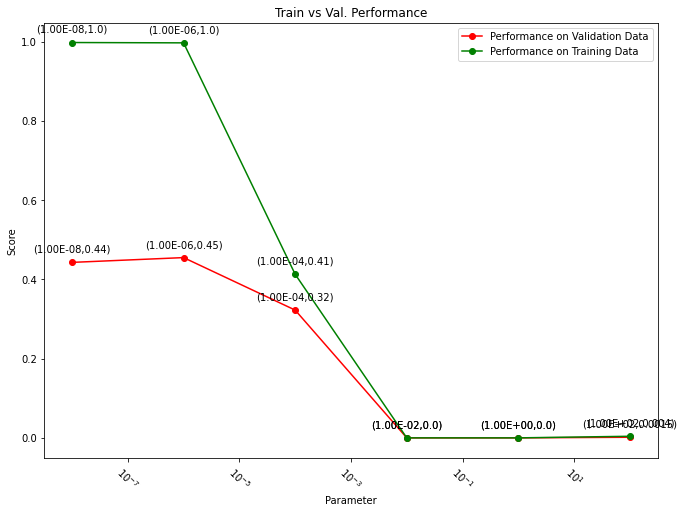

In [ ]:
%matplotlib inline

tradeoff_plot1D(params = OptSVM.cv_results_['param_OVRsvm__estimator__alpha'].compressed(), 
                TestScore = OptSVM.cv_results_['mean_test_score'], 
                TrainScore = OptSVM.cv_results_['mean_train_score'])

In [ ]:
with open("x_test.pkl", 'rb') as test, open("x_train.pkl", 'rb') as train: 
    x_test_multilabel = pickle.load(test)
    x_train_multilabel = pickle.load(train)

In [ ]:
OptClassifier = OneVsRestClassifier(estimator = SGDClassifier(loss='hinge', penalty='l1', alpha = 1e-6))
OptClassifier.fit(x_train_multilabel, y_train)

predictions = OptClassifier.predict(x_test_multilabel)

print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))

precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))


Accuracy : 0.1754783652243483
Hamming loss  0.0034773651576771787
Micro-average quality numbers
Precision: 0.5472, Recall: 0.3930, F1-measure: 0.4575
Macro-average quality numbers
Precision: 0.4469, Recall: 0.3112, F1-measure: 0.3559
              precision    recall  f1-score   support

           0       0.49      0.44      0.47      1111
           1       0.38      0.34      0.36      2052
           2       0.51      0.44      0.47      2387
           3       0.64      0.56      0.60      2226
           4       0.61      0.52      0.56      2014
           5       0.24      0.17      0.20       642
           6       0.58      0.42      0.49      1756
           7       0.85      0.73      0.79      1689
           8       0.42      0.25      0.32       341
           9       0.76      0.77      0.77      2344
          10       0.51      0.43      0.46       821
          11       0.38      0.30      0.33      1143
          12       0.58      0.43      0.49       768
         

In [ ]:
joblib.dump(OptClassifier, "Optimal_OVRSVM_triple_title_wgt.pkl")

del OptSVM, predictions

### Comments - 
Even after using smaller sample size i.e. approximately 1/3rd of 0.5M data points to train the Logistic Regression, SGD with Logloss & SGD with Hingeloss model; with careful hyperparameter tuning & including 4-grams in addition to 1,2 & 3-grams able to get comparable model performance in terms of Micro & Macro averaged F1 score, found best model to be Logistic Regression where c value was set to 4, with a Micro F1 score of 0.47 and Macro F1 score of 0.36. Also Linear SVM Model didn't perform well when compared to Logistic Regression model